### Model Load

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('../')
sys.path.append('./')
from model_module.model.fullmodel import DepthFullModel
from model_module.model.depth.resnet_encoder import ResnetEncoder
from model_module.model.depth.depth_classification import DepthClassification

In [2]:
depth_encoder = ResnetEncoder(layers=18)
depth_classification = DepthClassification()
model = DepthFullModel(depth_encoder = depth_encoder, depth_classification= depth_classification)

In [3]:
ckpt = torch.load('/usr/src/CV_For_Autonomous_Driving/model_module/model/weights/bin/abs_rel=0.1648.ckpt', map_location='cpu')

In [4]:
def load_state_dict(model, state_dict, prefix='', ignore_missing="relative_position_index"):
    missing_keys = []
    unexpected_keys = []
    error_msgs = []
    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, '_metadata', None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=''):
        local_metadata = {} if metadata is None else metadata.get(
            prefix[:-1], {})
        module._load_from_state_dict(
            state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + '.')

    load(model, prefix=prefix)

    warn_missing_keys = []
    ignore_missing_keys = []
    for key in missing_keys:
        keep_flag = True
        for ignore_key in ignore_missing.split('|'):
            if ignore_key in key:
                keep_flag = False
                break
        if keep_flag:
            warn_missing_keys.append(key)
        else:
            ignore_missing_keys.append(key)

    missing_keys = warn_missing_keys

    if len(missing_keys) > 0:
        print("Weights of {} not initialized from pretrained model: {}".format(
            model.__class__.__name__, missing_keys))
    if len(unexpected_keys) > 0:
        print("Weights from pretrained model not used in {}: {}".format(
            model.__class__.__name__, unexpected_keys))
    if len(ignore_missing_keys) > 0:
        print("Ignored weights of {} not initialized from pretrained model: {}".format(
            model.__class__.__name__, ignore_missing_keys))
    if len(error_msgs) > 0:
        print('\n'.join(error_msgs))

In [5]:
state_dict = ckpt['state_dict']
load_state_dict(model, state_dict, prefix='fullmodel.')

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig
from data_module.lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [7]:
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[3], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[5], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole


def merge_rgbs_raw(imgs):

    print(imgs[0].shape)

    fl = imgs[0]
    ff = imgs[1]
    fr = imgs[2]

    front = np.hstack([fl, ff, fr])
    print(front.shape)

    bl = imgs[3]
    bf = imgs[4]
    br = imgs[5]

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole


def vis_gt(bev):
    bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    return vis

In [8]:
# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config_debug.yaml')

    
setup_config(cfg, setup)

# dataset list 만드는 test
DM = DataModule('nuscenes_generated', cfg.data, cfg.loader)
split = 'train'
data_cfg_our = DM.data_cfg
datasets = DM.get_data(split=split,
                            **data_cfg_our)
# val_dataloader = DM.val_dataloader()
# data = next(iter(val_dataloader))


/tmp/ipykernel_935131/2484885166.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=CONFIG_PATH):


In [9]:
cfg.data

{'dataset': 'nuscenes_generated', 'num_classes': 12, 'version': 'v1.0-trainval', 'dataset_dir': '/usr/src/nuscenes', 'labels_dir': '/usr/src/nuscenes/cvt_labels_nuscenes_v2', 'label_indices': [[0, 1]], 'cameras': [[0, 1, 2, 3, 4, 5]], 'bev': {'h': 128, 'w': 128, 'h_meters': 102.4, 'w_meters': 102.4, 'offset': 0.0}, 'augment': 'none', 'image': {'h': 256, 'w': 704, 'top_crop': 54}, 'img_conf': {'img_mean': [123.675, 116.28, 103.53], 'img_std': [58.395, 57.12, 57.375], 'to_rgb': True}, 'ida_aug_conf': {'resize_lim': [0.386, 0.55], 'final_dim': [256, 704], 'rot_lim': [0, 0], 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': [0.0, 0.0], 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'Ncams': 6}, 'bda_aug_conf': {'rot_lim': [-22.5, 22.5], 'scale_lim': [0.95, 1.05], 'flip_dx_ratio': 0.5, 'flip_dy_ratio': 0.5}, 'data_root': '/usr/src/nuscenes', 'num_sweeps': 0, 'sweep_idxes': [], 'key_idxes': [], 'classes': ['car', 'truck', 'con

In [666]:
batch = datasets[10].__getitem__(5)

In [667]:
for k, v in batch.items():
    print(k)
    if (isinstance(v, torch.Tensor)):
        batch[k] = v.unsqueeze(0)

raw_images
cam_idx
image
gt_seg
intrinsics
extrinsics
sensor2sensor_mats
sensor2ego_mats
ida_mats
img_metas
depths
gt_boxes
gt_labels
bda_mat


In [668]:
batch['image'].shape

torch.Size([1, 6, 3, 256, 704])

In [669]:

output = model(batch)

In [670]:
output.keys()

dict_keys(['depth_bin'])

In [671]:
output['depth_bin'].shape

torch.Size([6, 112, 64, 176])

In [672]:
bin_pred = F.interpolate(output['depth_bin'].detach(), (256, 704), mode='bilinear')
bin_pred_4 = torch.argmax(output['depth_bin'].detach(), dim=1, keepdim=True) * 0.5 + 2
pred_depth_bin = bin_pred.detach()
pred_depth_bin = torch.argmax(pred_depth_bin, dim=1, keepdim=True) * 0.5 + 2 #112 bin -> value

In [673]:
bin_pred_4.shape

torch.Size([6, 1, 64, 176])

In [674]:
pred_depth_bin.shape

torch.Size([6, 1, 256, 704])

(-0.5, 703.5, 255.5, -0.5)

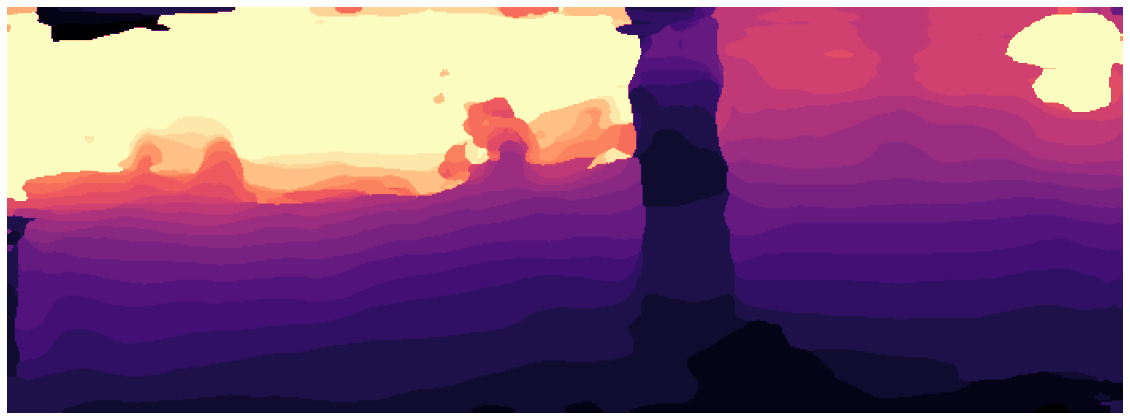

In [675]:
number = 3
pred_bin = pred_depth_bin[number].squeeze().cpu().numpy()
bin_vmax = np.percentile(pred_bin, 82)

fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
# ax1.imshow(np.transpose(img[number].numpy().astype(np.int8) * 100, (1,2,0)))
# viz_img = batch['raw_images'][0][number].cpu().numpy()
# ax1.imshow(viz_img)
ax1.imshow(pred_bin, cmap='magma', vmax=bin_vmax)


ax1.axis(False)

In [676]:
cfg.model.voxel_pooling

{'x_bound': [-51.2, 51.2, 0.8], 'y_bound': [-51.2, 51.2, 0.8], 'z_bound': [-5, 3, 8], 'd_bound': [2, 58, 0.5], 'final_dim': [256, 704], 'output_channels': 64, 'downsample_factor': 4}

In [677]:
from model_module.model.detection.voxel_pooling_pred_depth_16d import VoxelModule
from model_module.model.detection.voxel_pooling_pred_depth_1d import VoxelModule_1d

In [678]:
voxel_pooling = VoxelModule(**cfg.model.voxel_pooling)
voxel_pooling_1d = VoxelModule_1d(**cfg.model.voxel_pooling)

In [679]:

intrinsics = torch.eye(4).expand(1, 6, 4, 4)    # B, 6, 3, 3
intrinsics = intrinsics.clone()
intrinsics[:,:,:3,:3] = batch['intrinsics'] 


mats_dict = {'sensor2ego_mats': batch['sensor2ego_mats'].unsqueeze(1).cuda(),
                    'intrin_mats': intrinsics.unsqueeze(1).cuda(),
                    'ida_mats': batch['ida_mats'].unsqueeze(1).cuda(),
                    'sensor2sensor_mats': batch['sensor2sensor_mats'].unsqueeze(1).cuda(),
                    'bda_mat': batch['bda_mat'].cuda()
                    }

In [680]:
geom_xyz = voxel_pooling_1d(bin_pred_4.cuda().unsqueeze(1),mats_dict = mats_dict, timestamps = None)

In [681]:
geom_xyz.shape

torch.Size([1, 6, 1, 64, 176, 3])

tensor(613.)


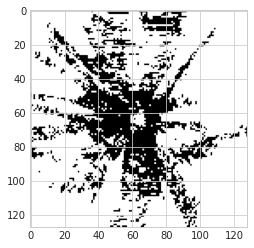

In [682]:
geom_xyz = geom_xyz.view(-1,3)

bev_grid = torch.zeros(128,128)
bev_grid_max = torch.zeros(128,128)
for i in range(geom_xyz.shape[0]):
    x,y = geom_xyz[i][0], geom_xyz[i][1]
    if x > 127 or y > 127 or x < 0 or y < 0:
        continue
    bev_grid[x][y] = 1
    bev_grid_max[x][y] += 1
    
max_point = bev_grid_max.max()
print(max_point)


plt.imshow(bev_grid)


In [683]:
bev_grid.shape


torch.Size([128, 128])

In [684]:
def get_downsampled_gt_depth_for_point(gt_depths):
        """
        Input:
            gt_depths: [B, N, H, W]
        Output:
            gt_depths: [B*N*h*w, d]
        """
        downsample_factor = 4
        B, N, H, W = gt_depths.shape
        gt_depths = gt_depths.view(
            B * N,
            H // downsample_factor,
            downsample_factor,
            W // downsample_factor,
            downsample_factor,
            1,
        )
        gt_depths = gt_depths.permute(0, 1, 3, 5, 2, 4).contiguous()
        gt_depths = gt_depths.view(
            -1, downsample_factor * downsample_factor)
        
        gt_depths_tmp = torch.where(gt_depths == 0.0,
                                    1e5 * torch.ones_like(gt_depths),
                                    gt_depths)
        
        gt_depths = torch.min(gt_depths_tmp, dim=-1).values
        
        gt_depths = gt_depths.view(B * N, H // downsample_factor,
                                   W // downsample_factor, 1)
        
        
        
        

        gt_depths = (gt_depths -
                     (2 - 0.5)) / 0.5
        
        gt_depths = torch.where(
            (gt_depths <= 112+1) & (gt_depths >= 0.0),
            gt_depths, torch.zeros_like(gt_depths))
        
        
        
        gt_depths = gt_depths.view(B , N, H // downsample_factor,
                                   W // downsample_factor, 1)
        
        zero_mask = gt_depths != 0.0
        
        
        
        # print(gt_depths.shape)
        # print(gt_depths[0].float())
        # exit()
        
        # gt_depths = F.one_hot(gt_depths.long(),
        #                       num_classes=2).view(
        #                           -1, 2)[:, 1:]
        

        return gt_depths.long().float() , zero_mask

In [685]:
gt_depth, zero_mask = get_downsampled_gt_depth_for_point(batch['depths'])
gt_depth = gt_depth*0.5 + 2 # b, n, 1, h, w
seg_mask = batch['gt_seg']

print(seg_mask.shape)

seg_mask = batch['gt_seg'].unsqueeze(2) == 1
print(seg_mask.shape)

torch.Size([1, 6, 64, 176])
torch.Size([1, 6, 1, 64, 176])


In [686]:
gt_depth = gt_depth.view(6, 1, 64, 176)

In [687]:
gt_voxel_pool = voxel_pooling_1d(gt_depth.cuda().unsqueeze(1),mats_dict = mats_dict, timestamps = None)

In [688]:
gt_voxel_pool.shape

torch.Size([1, 6, 1, 64, 176, 3])

In [689]:
print(seg_mask.shape)

torch.Size([1, 6, 1, 64, 176])


tensor(3827.)


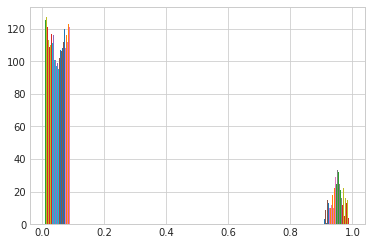

In [690]:
zero_mask = zero_mask.permute(0,1,4,2,3)
zero_mask = zero_mask.reshape(-1)
seg_mask = seg_mask.reshape(-1)
seg_zero_mask = zero_mask * seg_mask

gt_voxel_pool = gt_voxel_pool.view(-1,3)

gt_voxel_pool_zero = gt_voxel_pool[zero_mask]
gt_voxel_pool_seg = gt_voxel_pool[seg_mask]
gt_voxel_pool_segzero = gt_voxel_pool[seg_zero_mask]

bev_grid_gt = torch.zeros(128,128)
bev_grid_gt_max = torch.zeros(128,128)
for i in range(gt_voxel_pool.shape[0]):
    x,y = gt_voxel_pool[i][0], gt_voxel_pool[i][1]
    if x > 127 or y > 127 or x < 0 or y < 0:
        continue
    bev_grid_gt[x][y] = 1
    bev_grid_gt_max[x][y] += 1
    
max_point = bev_grid_gt_max.max()
print(max_point)

plt.hist(bev_grid_gt)
plt.show()


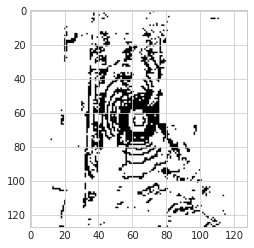

In [691]:
plt.imshow(bev_grid_gt)

tensor(25.)


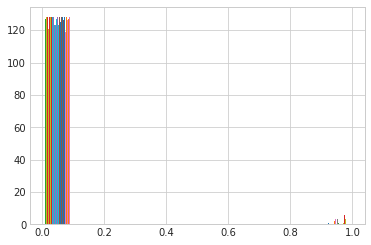

In [692]:

pred_point_segzero = geom_xyz[seg_zero_mask]

bev_grid_pred_seg = torch.zeros(128,128)
bev_grid_pred_seg_max = torch.zeros(128,128)
for i in range(pred_point_segzero.shape[0]):
    x,y = pred_point_segzero[i][0], pred_point_segzero[i][1]
    if x > 127 or y > 127 or x < 0 or y < 0:
        continue
    bev_grid_pred_seg[x][y] = 1
    bev_grid_pred_seg_max[x][y] += 1
    
max_point = bev_grid_pred_seg_max.max()
print(max_point)

plt.hist(bev_grid_pred_seg)
plt.show()

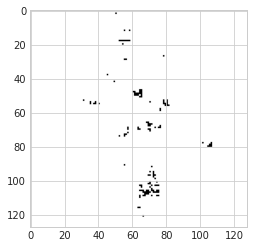

In [693]:
plt.imshow(bev_grid_pred_seg)

tensor(1.)


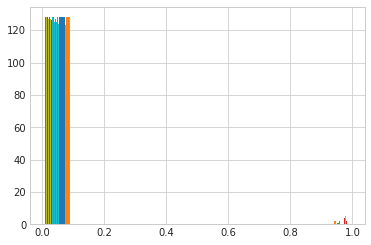

In [694]:
bev_grid_gt_seg = torch.zeros(128,128)
bev_grid_gt_seg_max = torch.zeros(128,128)
for i in range(gt_voxel_pool_segzero.shape[0]):
    x,y = gt_voxel_pool_segzero[i][0], gt_voxel_pool_segzero[i][1]
    if x > 127 or y > 127 or x < 0 or y < 0:
        continue
    bev_grid_gt_seg[x][y] = 1
    bev_grid_gt_seg_max[x][y] += 1
    
max_point = bev_grid_gt_seg.max()
print(max_point)

plt.hist(bev_grid_gt_seg)
plt.show()

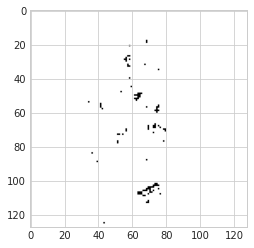

In [695]:
plt.imshow(bev_grid_gt_seg)

In [696]:
batch['raw_images'][0].shape

torch.Size([6, 3, 256, 704])

In [697]:
merge_rgb = merge_rgbs(batch['raw_images'][0].numpy())
print(merge_rgb.shape)

(512, 2112, 3)


In [698]:
cam = {0 : "FRONT_LEFT", 1 :"FRONT", 2 : "FRONT_RIGHT", 3 : "BACK_LEFT", 4 : "BACK", 5 : "BACK_RIGHT"}

In [699]:
def rotate_points_along_z(points, angle):
        """
        Args:
            points: (B, N, 3 + C)
            angle: (B), angle along z-axis, angle increases x ==> y
        Returns:
        """
        cosa = np.cos(angle)
        sina = np.sin(angle)
        zeros = np.zeros(points.shape[0])
        ones = np.ones(points.shape[0])
        rot_matrix = np.stack(
            (cosa, sina, zeros, -sina, cosa, zeros, zeros, zeros, ones),
            axis=1).reshape(-1, 3, 3)
        points_rot = np.matmul(points[:, :, 0:3], rot_matrix)
        points_rot = np.concatenate((points_rot, points[:, :, 3:]), axis=-1)
        return points_rot


def get_bev_lines(corners):
    return [[[corners[i, 0], corners[(i + 1) % 4, 0]],
             [corners[i, 1], corners[(i + 1) % 4, 1]]] for i in range(4)]

def get_corners(boxes3d):
    """
        7 -------- 4
       /|         /|
      6 -------- 5 .
      | |        | |
      . 3 -------- 0
      |/         |/
      2 -------- 1
    Args:
        boxes3d:  (N, 7) [x, y, z, dx, dy, dz, heading],
            (x, y, z) is the box center
    Returns:
    """
    template = (np.array((
        [1, 1, -1],
        [1, -1, -1],
        [-1, -1, -1],
        [-1, 1, -1],
        [1, 1, 1],
        [1, -1, 1],
        [-1, -1, 1],
        [-1, 1, 1],
    )) / 2)
    corners3d = np.tile(boxes3d[:, None, 3:6],
                        [1, 8, 1]) * template[None, :, :]
    corners3d = rotate_points_along_z(corners3d.reshape(-1, 8, 3),
                                          boxes3d[:, 6]).reshape(-1, 8, 3)
    corners3d += boxes3d[:, None, 0:3]
    return corners3d

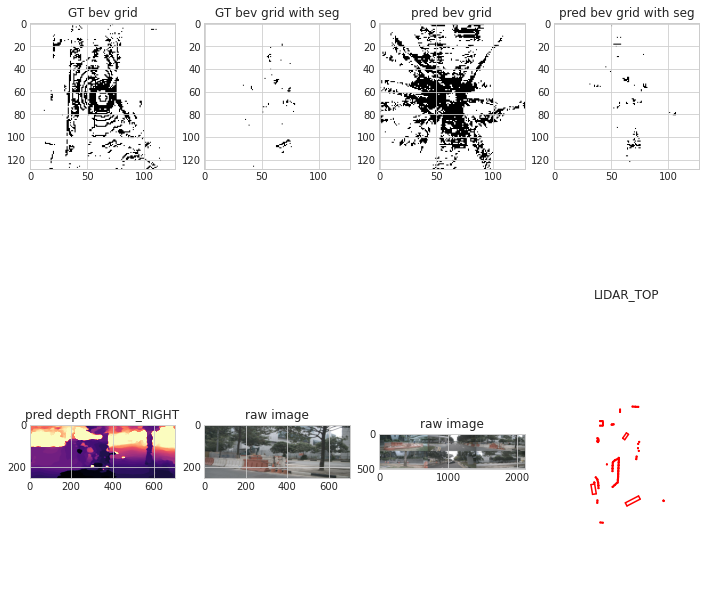

In [700]:
fig, ax1 = plt.subplots(2, 4, figsize=(12, 12))
ax1[0,0].imshow(bev_grid_gt)
ax1[0,0].set_title("GT bev grid")
ax1[0,1].imshow(bev_grid_gt_seg)
ax1[0,1].set_title("GT bev grid with seg")
ax1[0,2].imshow(bev_grid)
ax1[0,2].set_title("pred bev grid")
ax1[0,3].imshow(bev_grid_pred_seg)
ax1[0,3].set_title("pred bev grid with seg")


number = 2
pred_bin = pred_depth_bin[number].squeeze().cpu().numpy()
bin_vmax = np.percentile(pred_bin, 82)
ax1[1,0].imshow(pred_bin, cmap='magma', vmax=bin_vmax)
ax1[1,0].set_title("pred depth {}".format(cam[number]))

viz_img = batch['raw_images'][0][number].cpu().numpy()
viz_img = np.transpose(viz_img, (1,2,0))
# viz_img_1 = batch['raw_images'][0][number+1].cpu().numpy()
# viz_img_1 = np.transpose(viz_img_1, (1,2,0))

ax1[1,1].imshow(viz_img)
ax1[1,1].set_title("raw image")
ax1[1,2].imshow(merge_rgb)
ax1[1,2].set_title("raw image")
gt_bbox = batch['gt_boxes'][0].cpu()
            
gt_corners = []
for i in range(len(gt_bbox)):
    box = gt_bbox[i].numpy()
    if np.linalg.norm(box[:2]) <= 60:
        corners = get_corners(box[None])[0]
        gt_corners.append(corners)

# ax1[1,3].figure(figsize=(10, 10))

# Set BEV attributes
ax1[1,3].set_title('LIDAR_TOP')
ax1[1,3].axis('equal')
ax1[1,3].axis('off')
ax1[1,3].set_xlim(-50, 50)
ax1[1,3].set_ylim(-50, 50)

for corners in gt_corners:
    lines = get_bev_lines(corners)
    for line in lines:

        ax1[1,3].plot([x for x in line[1]],
                    [-x for x in line[0]],
                    c='r',
                    label='ground truth')
        
        
# ax1[1,3].show()
# ax1[1,3].set_title("raw image")


(-0.5, 2111.5, 511.5, -0.5)

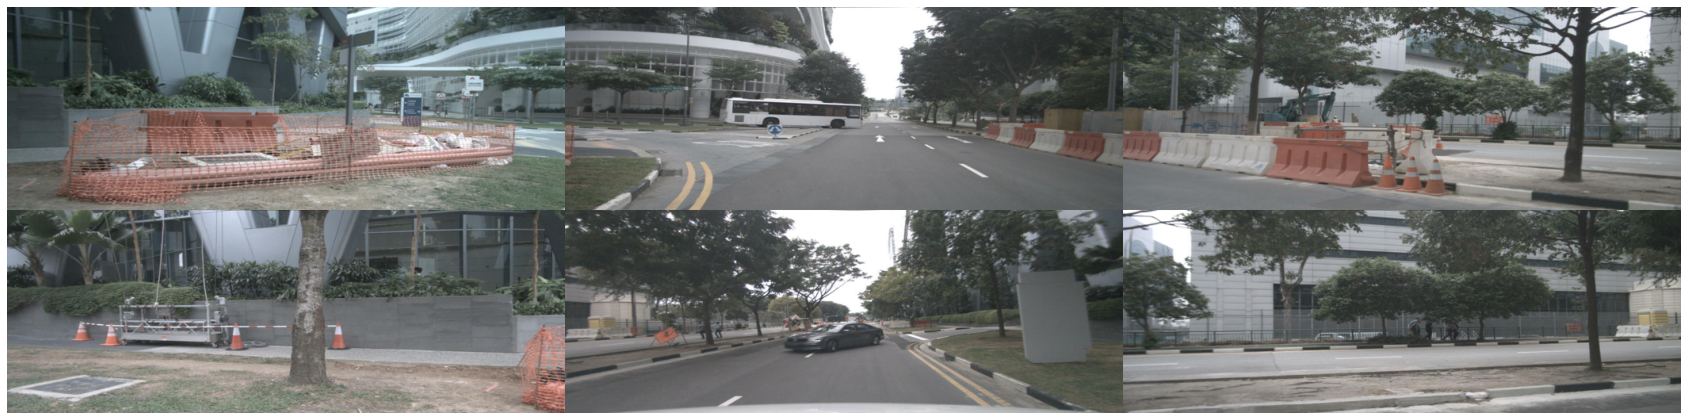

In [701]:
fig, ax1 = plt.subplots(1, 1, figsize=(30, 30))
ax1.imshow(merge_rgb)
ax1.axis(False)